**Benedictus Bayu Pramudhito**

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from warnings import catch_warnings, filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [19]:
def parser(x):
  return datetime.strptime(x, '%Y-%m')

In [26]:
dataset = pd.read_csv(r'./drive/My Drive/Colab Test (Bootcamp ML 2020)/sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
dataset.head()

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
Name: Sales, dtype: int64

**Nomor 1**

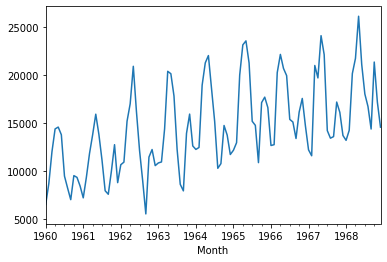

In [27]:
dataset.plot()
plt.show()

**Nomor 2**

Dalam data terdapat trend dan seasonal, oleh karena itu akan dilihat memakai arima dan sarima

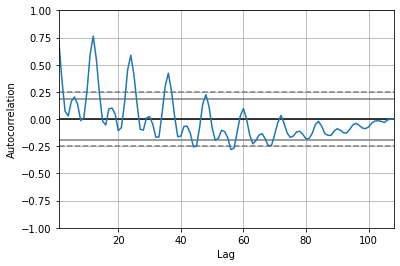

In [28]:
pd.plotting.autocorrelation_plot(dataset)
plt.show()

**Nomor 3**

In [36]:
values = dataset.values
size = int(len(values) * 0.7)
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []

In [37]:
model = AR(train)
model_fit = model.fit()
print('Lag:', model_fit.k_ar)
print('Coefficients:', model_fit.params)

Lag: 11
Coefficients: [ 7.19120783e+02  5.55091877e-01  9.44856038e-02 -2.13772324e-01
 -5.71696929e-02  1.69697917e-01 -3.77367914e-02  5.70418197e-02
 -1.14844363e-01 -2.84221826e-04 -1.18836717e-01  6.63698139e-01]


In [38]:
dataset_values = dataset.values

def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.8)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [39]:
import warnings

p_values = range(0, 8)
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=28195232.967
ARIMA(0, 0, 1) MSE=17145492.120
ARIMA(0, 1, 0) MSE=16861609.466
ARIMA(0, 1, 1) MSE=18339183.147
ARIMA(1, 0, 0) MSE=14646375.971
ARIMA(1, 0, 1) MSE=15400642.327
ARIMA(1, 1, 0) MSE=18139717.723
ARIMA(2, 0, 0) MSE=15687644.365
ARIMA(2, 0, 1) MSE=15670737.813
ARIMA(2, 1, 0) MSE=19004805.727
ARIMA(3, 0, 0) MSE=15634584.625
ARIMA(3, 0, 1) MSE=13471106.021
ARIMA(3, 1, 0) MSE=16305321.929
ARIMA(4, 0, 0) MSE=14949955.594
ARIMA(4, 0, 1) MSE=14224920.551
ARIMA(4, 1, 0) MSE=14169479.835
ARIMA(5, 0, 0) MSE=13843033.695
ARIMA(5, 0, 1) MSE=16166058.193
ARIMA(5, 1, 0) MSE=13176496.773
ARIMA(6, 0, 0) MSE=12206660.474
ARIMA(6, 0, 1) MSE=12292229.639
ARIMA(6, 1, 0) MSE=13150420.138
ARIMA(7, 0, 0) MSE=12390184.757
ARIMA(7, 0, 1) MSE=12546344.926
ARIMA(7, 1, 0) MSE=13790374.863
Best ARIMA(6, 0, 0) MSE=12206660.474


Untuk dataset birth nilai MSE terbaik diperoleh dengan nilai 12206660.474 dengan :
* nilai p = 6 yang artinya data yang dilihat berdasarkan 6 data waktu sebelumnya
* nilai d yang digunakan untuk membuat data stationary dengan nilai = 0
* nilai q yang menggabungkan ketergantungan antara observasi dan nilai residual dari model moving average yang diterapkan pada nilai lag yang diamati dengan nilai 0


**Nomor 4**

In [43]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [3]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [44]:
n_test = int(len(dataset) * 0.7)

# model configs
cfg_list = sarima_configs()

# grid search
scores = grid_search(dataset, cfg_list, n_test)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

 > Model[[(3, 0, 0), (0, 0, 0, 0), 'n']] 3600.859
 > Model[[(3, 0, 0), (0, 0, 1, 0), 'n']] 3307.676
 > Model[[(3, 0, 0), (0, 0, 2, 0), 'n']] 3537.401
 > Model[[(3, 0, 0), (1, 0, 0, 0), 'n']] 3354.301
 > Model[[(3, 0, 0), (1, 0, 1, 0), 'n']] 3198.515
 > Model[[(3, 0, 0), (1, 0, 2, 0), 'n']] 3190.844
 > Model[[(3, 0, 0), (2, 0, 0, 0), 'n']] 3226.689
 > Model[[(3, 0, 0), (2, 0, 1, 0), 'n']] 3236.808
 > Model[[(3, 0, 0), (0, 0, 0, 0), 'c']] 3301.634
 > Model[[(3, 0, 0), (0, 0, 1, 0), 'c']] 3241.142
 > Model[[(3, 0, 0), (2, 0, 2, 0), 'n']] 3080.446
 > Model[[(3, 0, 0), (1, 0, 0, 0), 'c']] 3222.431
 > Model[[(3, 0, 0), (0, 0, 2, 0), 'c']] 3223.983
 > Model[[(3, 0, 0), (1, 0, 1, 0), 'c']] 3223.468
 > Model[[(3, 0, 0), (1, 0, 2, 0), 'c']] 3009.078
 > Model[[(3, 0, 0), (2, 0, 0, 0), 'c']] 3231.115
 > Model[[(3, 0, 0), (2, 0, 1, 0), 'c']] 3203.566
 > Model[[(3, 0, 0), (0, 0, 0, 0), 't']] 3563.639
 > Model[[(3, 0, 0), (2, 0, 2, 0), 'c']] 2832.343
 > Model[[(3, 0, 0), (0, 0, 1, 0), 't']] 3544.227


Berdasarkan hasil sarima, nilai RMSE terbaik diperoleh pada nilai Model [[(3,1,2), (2,0,2,0), 'n'] dengan nilai RMSE 2306.767816955838 dengan lag(**p**) berniali 3, **d** bernilai 1, dan **q** bernilai 0 untuk bagian **autoregression**nya

Untuk **seasonal**nya parameternya dengan **P** bernilai 2, **D** bernilai 0, **Q** bernilai 2, dan **m** bernilai 0. 

Untuk trendnya bernilai n yang berarti No Trend yang artinya secara grafik tidak terlihat trend dan seasonalitynya

**Nomor 5**

* ARIMA -> Best ARIMA(6, 0, 0) MSE=12206660.474, RMSE = 3493.803
* SARIMA -> Model [[(3,1,2), (2,0,2,0), 'n'], RMSE = 2306.767816955838

Berdasarkan RMSE, hasil lebih baik ditunjukkan oleh SARIMA yang berarti tidak menunjukkan adanya trend dan seasonality